#**CS 422 Project Report - Arinjay Jain**

#Abstract
In this project we are going to see what are steps need to take to build a data science project from gathering data to model deployment and how we can share the model with other teams or person so they can use the already built model on unseen datasets.

As in results, we build a pipeline, using the Machine Learning classification model. We will create an **ONNX** file using the *SKlearn ONNX* package. Then deployed and run on an actual data set to produce results.

#Overview
Problem Statement: We have given sampled dataset and our objective is to build a model and ONNX file for deployment. 

Given a dataset need to build an efficient model and onnx file using the pipeline. The data is processed and imputed with the mean of the individual columns. Then Random Forest classifier model is chosen for this given dataset. The output of the project will be a .onnx file.

Importing Data in Google Colab

In [ ]:
from google.colab import files
files.upload()

Saving data_public.csv.gz to data_public.csv.gz


In [1]:
pip install skl2onnx

     |████████████████████████████████| 235kB 5.8MB/s 
     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 12.2MB 309kB/s 


In [2]:
!pip install onnxruntime

     |████████████████████████████████| 4.1MB 3.4MB/s 


In [3]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import graphviz

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#data set
data = pd.read_csv('/content/drive/MyDrive/Spring Data Mining 422/Project/data_public.csv.gz')

In [6]:
data.head(4)

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,3
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2


# Data Processing and Analysis

 

####Check missing value and cleaning data

In [7]:
data.isna().sum()

A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64

In [8]:
data.dtypes


A        float64
B        float64
C        float64
D        float64
E        float64
F        float64
G        float64
H        float64
I        float64
J        float64
K        float64
L        float64
M        float64
N        float64
O        float64
Class      int64
dtype: object

So we do not have any missing and corrupted data 

In [9]:
#summary of data
data.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,5.068656e+01,-1.883373e+01,7.162152e+01,-1.355120e+01,2.944177e+01,-6.185189e+00,3.174186e+01,5.112504e+01,3.300077e+01,4.092546e+01,7.938340e+01,-6.746540e+00,-4.232290e+01,4.949012e+01,5.980333e+01,2.167323e+00
std,1.292492e+02,1.446355e+01,1.052808e+02,4.689774e+01,7.282278e+01,7.309100e+01,6.660329e+01,1.034053e+02,4.217119e+01,7.694386e+01,9.484003e+01,1.557490e+01,1.791142e+01,6.728231e+01,6.677712e+01,6.874930e-01
min,-7.308940e+01,-8.322357e+01,-5.972853e+01,-1.375818e+02,-3.829826e+01,-1.485917e+02,-6.654137e+01,-4.246089e+01,-1.818542e+01,-1.123844e+02,-1.415233e+01,-6.271828e+01,-8.144988e+01,-2.057979e+01,-1.283059e+01,1.000000e+00
25%,-3.793679e+01,-1.786669e+01,7.553164e+00,-1.471337e+01,-2.436286e+01,-3.072492e+01,-3.484185e+00,-2.629661e+01,-7.594991e+00,2.108044e+01,2.419273e+00,-8.875128e+00,-5.567326e+01,-7.131906e+00,1.628438e-01,2.000000e+00
50%,-3.197847e+01,-1.369876e+01,1.348796e+01,-8.004308e+00,-1.897058e+01,-2.475391e+01,1.491431e+00,-1.817028e+01,3.769369e+01,2.717432e+01,2.652955e+01,-1.079123e+00,-5.297585e+01,1.462293e+01,4.689262e+01,2.000000e+00
75%,2.280020e+02,-1.055606e+01,2.123439e+02,1.955806e+01,1.289018e+02,7.834417e+01,1.151840e+02,1.915891e+02,7.984842e+01,1.253846e+02,2.046458e+02,3.334451e+00,-2.208504e+01,1.363603e+02,1.451293e+02,3.000000e+00
max,2.687738e+02,4.460108e+00,2.561698e+02,3.263799e+01,1.579843e+02,1.229186e+02,1.660534e+02,2.329496e+02,1.112970e+02,1.755397e+02,2.598003e+02,2.159496e+01,1.032828e+01,1.789303e+02,1.807011e+02,3.000000e+00


#### Let's looking into the frequency for each class in the target variable.  

In [13]:
data['Class'].value_counts()

2    599228
3    400780
1    199992
Name: Class, dtype: int64

### Percentage present of each class in data sets, And we found highly imbalanced classes. We have **50%** of class **2** and **33%** of class **3** and just **16%** of class **1**

In [18]:
print(data['Class'].value_counts()/data['Class'].value_counts().sum()*100)

2    49.935667
3    33.398333
1    16.666000
Name: Class, dtype: float64


##Correlation Matrix

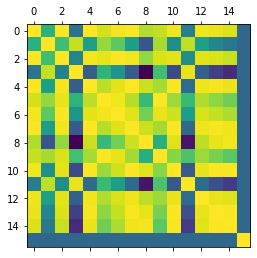

In [19]:
plt.matshow(data.corr())
plt.show()

####We can see here we do not have very strong correlation between target(class) variable and other feature variables.  

So there is no point to drop any feature variables.

In [20]:
data.corr('pearson')

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
A,1.000000,0.455949,0.991999,0.071330,0.990703,0.905353,0.972223,0.988807,0.818399,0.870016,0.968827,0.139619,0.958931,0.953081,0.920322,-0.000620
B,0.455949,1.000000,0.541742,0.865856,0.352946,0.760708,0.620607,0.339549,-0.098558,0.803246,0.246429,0.854635,0.345030,0.194578,0.098805,0.000138
C,0.991999,0.541742,1.000000,0.176224,0.971805,0.943482,0.988351,0.968342,0.753474,0.915784,0.937868,0.238723,0.941040,0.916578,0.873800,-0.000686
D,0.071330,0.865856,0.176224,1.000000,-0.047459,0.477183,0.279248,-0.062451,-0.502643,0.544357,-0.163679,0.949485,-0.042057,-0.217856,-0.316241,0.000150
E,0.990703,0.352946,0.971805,-0.047459,1.000000,0.849129,0.939705,0.997116,0.879142,0.805749,0.989217,0.026319,0.964769,0.979925,0.958885,-0.000649
F,0.905353,0.760708,0.943482,0.477183,0.849129,1.000000,0.969055,0.841227,0.508345,0.989868,0.781534,0.518117,0.823551,0.745156,0.675416,-0.000540
G,0.972223,0.620607,0.988351,0.279248,0.939705,0.969055,1.000000,0.934714,0.678043,0.949429,0.894114,0.335039,0.910385,0.867546,0.815281,-0.000472
H,0.988807,0.339549,0.968342,-0.062451,0.997116,0.841227,0.934714,1.000000,0.886017,0.796856,0.990875,0.012005,0.964627,0.982403,0.962873,-0.000670
I,0.818399,-0.098558,0.753474,-0.502643,0.879142,0.508345,0.678043,0.886017,1.000000,0.439881,0.926217,-0.418110,0.848801,0.943365,0.970965,-0.000766
J,0.870016,0.803246,0.915784,0.544357,0.805749,0.989868,0.949429,0.796856,0.439881,1.000000,0.730841,0.579309,0.781815,0.691273,0.615931,-0.000333


##Data Processsing:

The data in the given dataset has significant amount of negative values for every features and we ahve 15 features in given datasets. 

The data is imputed with mean of each column. An sklearn pipeline is built, with column transformation and classifier.

In [21]:
# get X and Y in out data sets so A-O will be our X and class will be Y
Y = data[['Class']]
X = data.drop(['Class'], axis=1)

In [22]:
## Divide the data in train and test

stratified_sampling = StratifiedShuffleSplit(n_splits=6, test_size=0.3, random_state=42)
stratified_sampling.get_n_splits(X, Y)

for train_index, test_index in stratified_sampling.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    Y_train, Y_test = Y.loc[train_index], Y.loc[test_index]

TRAIN: [ 778764  991315  616125 ... 1054762  929382  246584] TEST: [440800 755505  14672 ... 480361 880393 294081]
TRAIN: [ 420200 1048374  944562 ...  814542  134218 1009666] TEST: [ 573604 1034825  379710 ...  433161  857384  777189]
TRAIN: [ 740925 1065358  884581 ...  467222  735300  346198] TEST: [ 520270  451003  195629 ... 1020353 1026947  533672]
TRAIN: [122155 650515   6838 ... 523377 801698 446702] TEST: [522048 217411 728177 ... 827966 854168 322787]
TRAIN: [ 130486 1037012  369285 ...  624365 1136468  543681] TEST: [ 427918 1196787   63472 ... 1022096  817560  931930]
TRAIN: [892016 803723 533026 ... 355179  44312 931019] TEST: [430987 568623 632169 ... 288370 714261 937859]


In [23]:
train_data = pd.concat([X_train, Y_train], axis=1)
#train_data.head()

In [24]:
test_data = pd.concat([X_test, Y_test], axis=1)
test_data.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
430987,-32.726917,-8.525324,15.996091,16.913023,-27.391240,-28.508286,5.261269,-29.843802,-8.711469,35.537022,2.352276,4.783837,-55.529432,-6.199949,1.173385,3
568623,-30.966055,-19.975955,7.006020,19.204725,-22.953425,-24.605902,3.775915,-28.534427,-10.442712,27.596098,3.643748,-0.745326,-56.170372,-7.617898,1.874840,3
632169,-60.533701,-48.897961,-42.288993,-113.862220,-21.464887,-119.854821,-50.176580,-17.320671,48.021959,-91.291658,42.655019,-34.520933,-39.795170,34.166175,67.057570,1
1033609,-38.295545,-14.851853,11.873488,21.766062,-22.518266,-24.152995,-2.381897,-29.238621,-4.167289,24.610347,13.134333,5.904119,-57.410327,-5.498198,2.876530,1
1038059,-27.747038,-11.539987,19.261715,23.681083,-24.054594,-13.333507,1.783816,-24.539398,-7.737608,19.376088,1.995280,-0.438257,-57.721949,-4.838183,-0.696083,2


In [25]:
# data pipeline

data_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

data_transformer = Pipeline(steps=[
    ('imputer',
     SimpleImputer(strategy='mean')),
    ('scaler',
     StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('data',
     data_transformer,
     data_features),
])

##Model Training:
The model chosen for this data set is Random Forest Classifier. This model is fast, it avoids over-fitting the data. The hyper-tuning parameters used to tune the model are:


**max_depth**=2 :- The maximum depth of the tree, **n_estimators**=1000 :- The number of trees in the forest, **n_jobs**=-1 :- The number of jobs to run in parallel for both fit and predict, **criterion**='gini' :- The function to measure the quality of a split, **random_state**=32 :- If int, random_state is the seed used by the random number generator, **max_features**= 2 :- The number of features to consider when looking for the best split, **max_leaf_nodes**=2 :- Grow trees with max_leaf_nodes in best-first fashion.

The data set was spilt according to stratified sampling using 'StratifiedShuffleSplit', with k-folds =6.The data was split into training and testing(validation) data set in 70-30 ratio. The model was then trained using the training data. The most important features of the model were identified. The 'SelectFromModel' function was used to select the best features from the model

In [26]:
classifier = RandomForestClassifier( max_depth=2, n_estimators=1000, n_jobs=-1, criterion='gini',
                                    random_state=32, class_weight=None,
                                    max_features= 2, max_leaf_nodes=2)

In [27]:
pipeline = Pipeline([
    ('precprocessor',
     preprocessor),
    ('feature_selection', 
    SelectFromModel(LinearSVC(C=1.0, loss='squared_hinge', penalty='l1', dual=False))),
    ('classifier',
     classifier)
])

In [28]:
pipeline.fit(train_data.drop('Class', axis=1), 
             train_data["Class"])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('precprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('data',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                             

#### Lets look for Important features in the data set

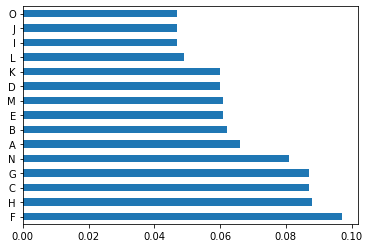

In [29]:
feat_importances = pd.Series(classifier.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

#Model Validation:

The model was validated/tested using the testing data set that was out-of-sample/test data from the stratified sampling that was not used during the model training. 

The results of the model in form of accuracy and f1 score.

F1-score : 0.3326175301652233

Accuracy : 0.49935555555555555

In [30]:
predictions = pipeline.predict(X_test)

In [31]:
predictions

array([2, 2, 2, ..., 2, 2, 2])

In [32]:
confusion_metrics = metrics.confusion_matrix(Y_test, predictions)
print("The confusion matrix is:")
print(confusion_metrics)

The confusion matrix is:
[[     0  59998      0]
 [     0 179768      0]
 [     0 120234      0]]


In [33]:
score = metrics.f1_score(Y_test, predictions, average = 'weighted')
print("The f1 score is:", score)
pscore = metrics.accuracy_score(Y_test, predictions)
print("The accuracy is:",pscore)

The f1 score is: 0.3326175301652233
The accuracy is: 0.49935555555555555


### ONNX Pipeline Model deployment 

In [34]:
input_types = dict([(x, FloatTensorType([None, 1])) for x in X_train.columns.values])
 
try:
    model_onnx = convert_sklearn(pipeline, 'Project_onnx', initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("/content/drive/MyDrive/Spring Data Mining 422/Project/Project.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [35]:
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("/content/drive/MyDrive/Spring Data Mining 422/Project/Project.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

predict [2 2 2 ... 2 2 2]


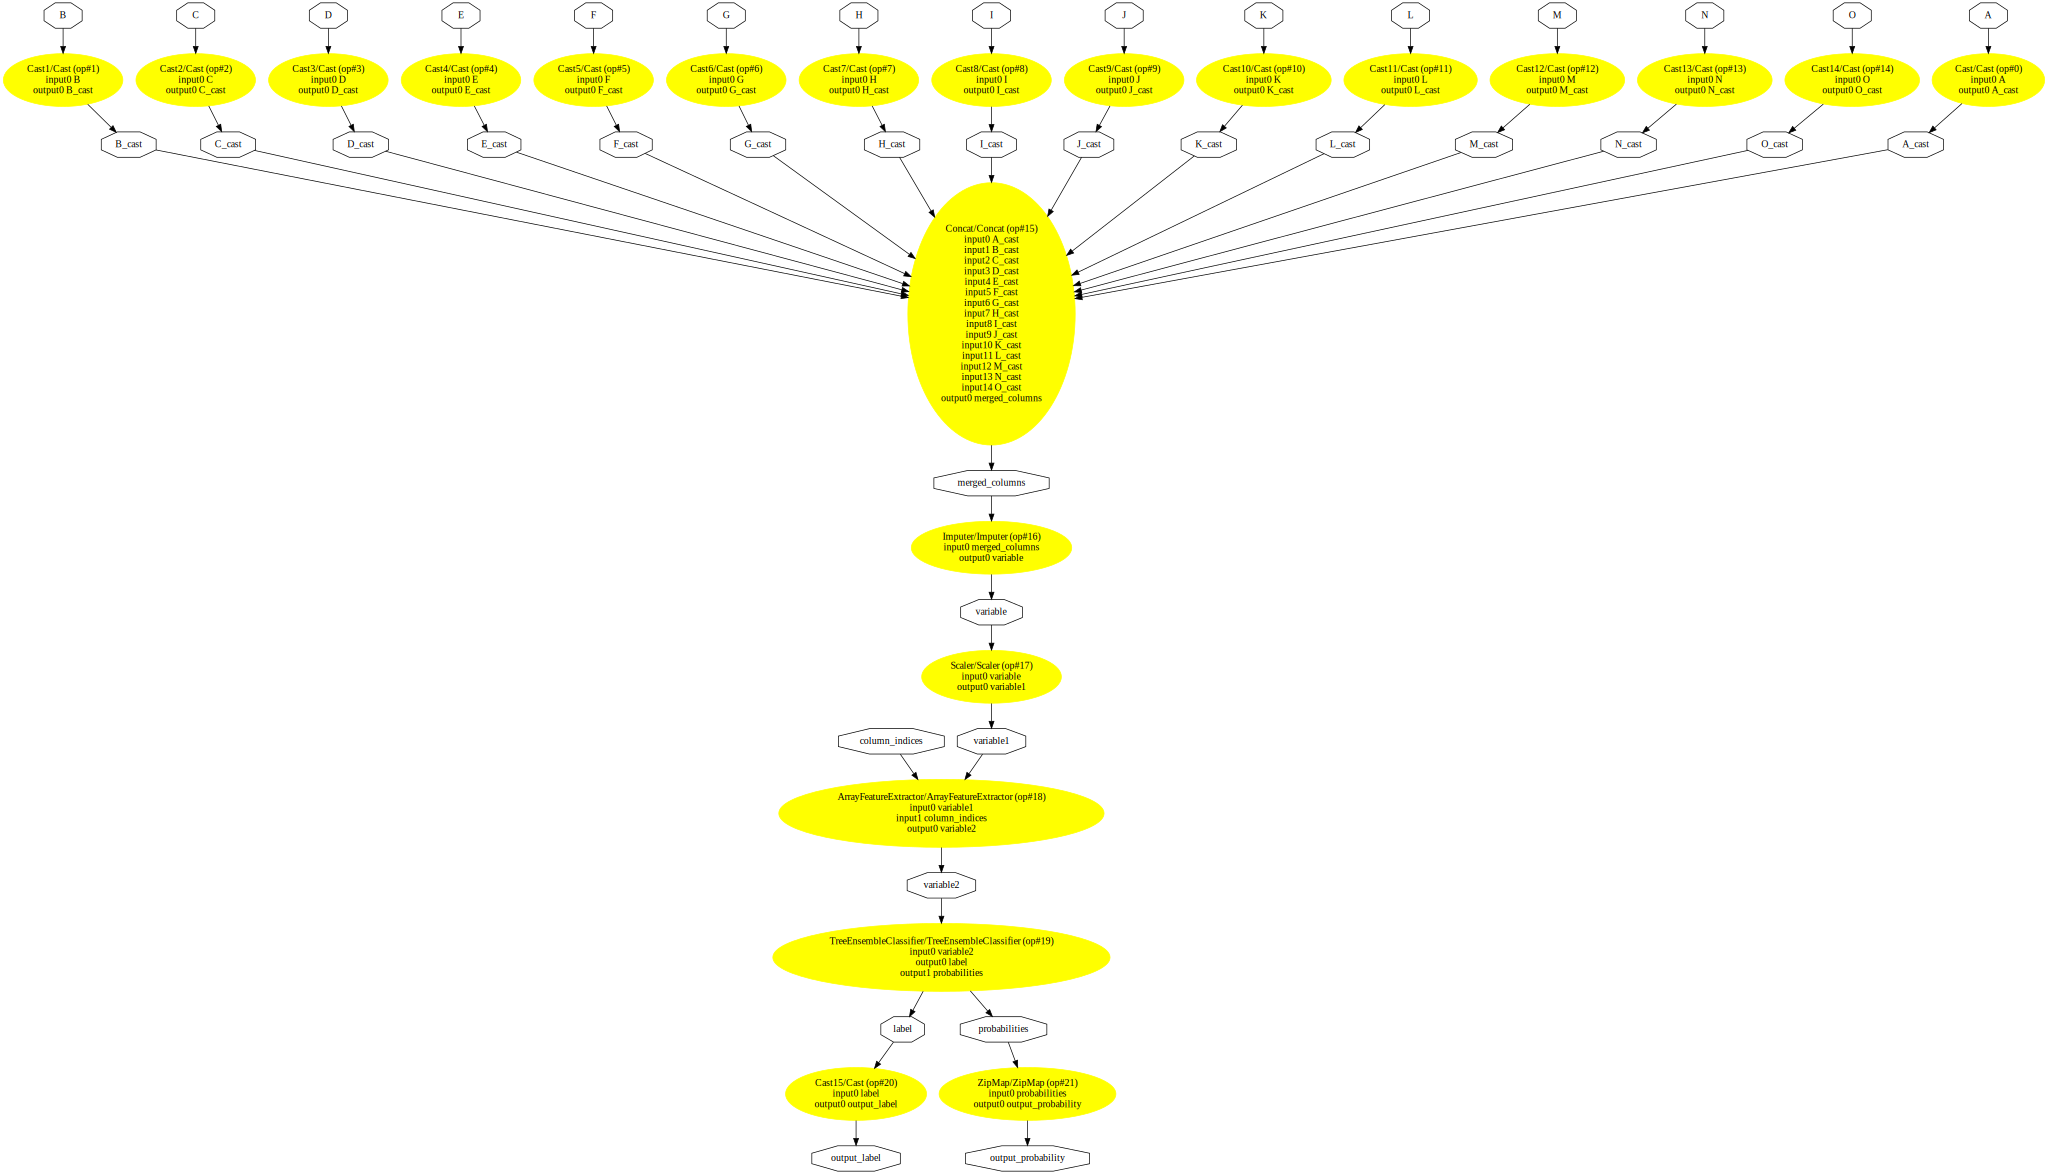

In [36]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))

graphviz.Source(pydot_graph)

# Conclusion:

We built a Random forest model with tuning parameters are 'max_depth', 'n_estimators', 'criterion', 'random_state', 'max_features', 'max_leaf_nodes'.

The pipeline was set up to pre-process the data from the file and impute(mean) its values and passed to the model built. The accuracy and f1 score of the model was calculated accordingly.

# Data Sources:

The data file(data_public.csv.gz) was given on blackboard by Professor.

# Source Code:
I referred to some open sources for the random forest model building and parameter tuning from these links below:



1. https://www.datacamp.com/community/tutorials/random-forests-classifier-python
2. https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
3. https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/








# Bibliography:


1. https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
3. https://scikit-learn.org/stable/modules/feature_selection.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
5. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
